In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Imports 
import os
import sys
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


# Data Loading and Preprocessing

In [ ]:
def normalize(data_x, data_y):
    #For features a Min-Max Scaler is used. Output array is normalized dividing by the maximum in the dataset.
    scaler = MinMaxScaler()
    scaler.fit(data_x)
    X_norm = scaler.transform(data_x)
    #HOLA
    max_y = max(data_y)
    y_norm = data_y / max_y


    return X_norm, y_norm


def make_train_val_data(csv_path):
    #First 6 columns are the features and 7th column is the output (ppi)
    df = pd.read_csv(csv_path)
    X = df.values[:,:6]
    y = df.values[:,6]

    return X, y

In [ ]:
csv_path = '/content/gdrive/My Drive/nubalu/dataset.csv'
X, y = make_train_val_data(csv_path)
#X_norm, y_norm = normalize(X, y)
X_norm, y_norm = normalize(X, y)

# First approach: SVR

First model is a Support-Vector Regressor. A Grid Search is used in order to establish best parameters: kernel and C. The error function that we want to optimize is mean squared error (but negated form used by sklearn). Best model corresponds to a linear kernel and 0.1 for C value, achieving a 0.0052 of mean squared error using a 10 k-fold cross validation.

In [ ]:
parameters = {'kernel': ('linear', 'rbf', 'poly'), 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
svr = SVR()
clf = GridSearchCV(svr, parameters, cv=10, scoring='neg_mean_squared_error')
clf.fit(X_norm, y_norm)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
clf.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [ ]:
clf.best_score_

-0.00517981415787462

# Second approach: Neural Network with 1 hidden layer

Second model is a simple Neural Network with 1 hidden layer. The error function that we want to optimize is mean squared error. After training, best model achieves a 0.0143 mean squared error on training and 0.0179  on validation. After training stage, a loss curve of training and validation losses through the epochs is attached.

In [ ]:
def model_arch(data, verbose=True):

  inp = keras.layers.Input(shape=(data.shape[1],), name='input_layer')

  x = keras.layers.Dense(3, activation='relu', name='hidden_layer_1')(inp)

  model_output = keras.layers.Dense(1, activation='linear', name='output_layer')(x)

  model = keras.models.Model(inputs=inp, outputs=model_output)
  model.compile(loss='mean_squared_error', optimizer='adam')

  if verbose is True:

        print(model.summary())

  return model



In [ ]:
ppi_model = model_arch(X_norm)





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 6)                 0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 3)                 21        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 4         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def plot_loss_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
def lr_onplateau(monitor, factor, patience, min_lr):
    lr = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=factor,
                                           patience=patience, min_lr=min_lr)
    return lr 
  
def early_stopping(monitor, min_delta, mode, patience):
    es = keras.callbacks.EarlyStopping(monitor=monitor, mode=mode, min_delta = min_delta,
                                       patience=patience)
    return es

get_lrplateau = lr_onplateau('val_loss', 0.75, 20, 0.000001)
es = early_stopping('val_loss', 0.00001, 'auto', 50)

In [ ]:
save_best = keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/nubalu/logs/ppi_model_1_layer.h5',save_best_only=True, monitor = 'val_loss')
csv_logger = keras.callbacks.CSVLogger('/content/gdrive/My Drive/nubalu/logs/training_progress_1_layer.log')

In [ ]:
epochs = 5000
batch_size = 32
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
history = ppi_model.fit(X_train, y_train, callbacks=[get_lrplateau, save_best, csv_logger, es],
     validation_data=(X_val, y_val), shuffle=True, batch_size=batch_size, epochs=epochs)




Train on 45 samples, validate on 5 samples
Epoch 1/5000





45/45 [==============================] - 5s 108ms/step - loss: 1.6464 - val_loss: 1.5092
Epoch 2/5000
45/45 [==============================] - 0s 314us/step - loss: 1.6231 - val_loss: 1.4863
Epoch 3/5000
45/45 [==============================] - 0s 266us/step - loss: 1.6001 - val_loss: 1.4639
Epoch 4/5000
45/45 [==============================] - 0s 299us/step - loss: 1.5772 - val_loss: 1.4417
Epoch 5/5000
45/45 [==============================] - 0s 239us/step - loss: 1.5548 - val_loss: 1.4203
Epoch 6/5000
45/45 [==============================] - 0s 239us/step - loss: 1.5324 - val_loss: 1.3996
Epoch 7/5000
45/45 [==============================] - 0s 280us/step - loss: 1.5112 - val_loss: 1.3791
Epoch 8/5000
45/45 [==============================] - 0s 212us/step - loss: 1.4895 - val_loss: 1.3589
Epoch 9/5000
45/45 [==============================] - 0s 289us/step - loss: 1.4683 - val_loss: 1.3391
Epoch 10/5000
45/45 [==========

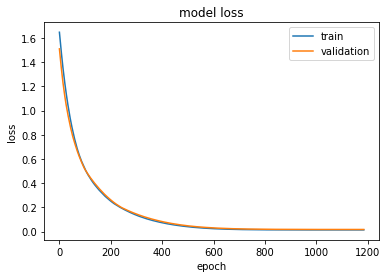

In [ ]:
plot_loss_history(history)

# Third approach: Neural Network with 2 hidden layers

Third model is a Neural Network with 2 hidden layer. The error function that we want to optimize is mean squared error. After training, best model achieves a 0.0018 mean squared error on training and 0.0033  on validation. After training stage, a loss curve of training and validation losses through the epochs is attached.

In [ ]:
def model_arch(data, verbose=True):

  inp = keras.layers.Input(shape=(data.shape[1],), name='input_layer')

  x = keras.layers.Dense(4, activation='relu', name='hidden_layer_1')(inp)

  x = keras.layers.Dense(2, activation='relu', name='hidden_layer_2')(x)

  model_output = keras.layers.Dense(1, activation='linear', name='output_layer')(x)

  model = keras.models.Model(inputs=inp, outputs=model_output)
  model.compile(loss='mean_squared_error', optimizer='adam')

  if verbose is True:

        print(model.summary())

  return model



In [ ]:
ppi_model = model_arch(X_norm)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 6)                 0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 4)                 28        
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 2)                 10        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def lr_onplateau(monitor, factor, patience, min_lr):
    lr = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=factor,
                                           patience=patience, min_lr=min_lr)
    return lr 
  
def early_stopping(monitor, min_delta, mode, patience):
    es = keras.callbacks.EarlyStopping(monitor=monitor, mode=mode, min_delta = min_delta,
                                       patience=patience)
    return es

get_lrplateau = lr_onplateau('val_loss', 0.75, 20, 0.000001)
es = early_stopping('val_loss', 0.00001, 'auto', 50)

In [ ]:
save_best = keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/nubalu/logs/ppi_model_2_layers.h5',save_best_only=True, monitor = 'val_loss')
csv_logger = keras.callbacks.CSVLogger('/content/gdrive/My Drive/nubalu/logs/training_progress_2_layers.log')

In [ ]:
epochs = 5000
batch_size = 32
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
history = ppi_model.fit(X_train, y_train, callbacks=[get_lrplateau, save_best, csv_logger, es],
     validation_data=(X_val, y_val), shuffle=True, batch_size=batch_size, epochs=epochs)

Train on 45 samples, validate on 5 samples
Epoch 1/5000
45/45 [==============================] - 0s 5ms/step - loss: 0.5017 - val_loss: 0.5435
Epoch 2/5000
45/45 [==============================] - 0s 278us/step - loss: 0.4938 - val_loss: 0.5368
Epoch 3/5000
45/45 [==============================] - 0s 277us/step - loss: 0.4862 - val_loss: 0.5302
Epoch 4/5000
45/45 [==============================] - 0s 284us/step - loss: 0.4780 - val_loss: 0.5235
Epoch 5/5000
45/45 [==============================] - 0s 276us/step - loss: 0.4693 - val_loss: 0.5168
Epoch 6/5000
45/45 [==============================] - 0s 332us/step - loss: 0.4619 - val_loss: 0.5100
Epoch 7/5000
45/45 [==============================] - 0s 300us/step - loss: 0.4536 - val_loss: 0.5033
Epoch 8/5000
45/45 [==============================] - 0s 296us/step - loss: 0.4454 - val_loss: 0.4966
Epoch 9/5000
45/45 [==============================] - 0s 260us/step - loss: 0.4376 - val_loss: 0.4899
Epoch 10/5000
45/45 [====================

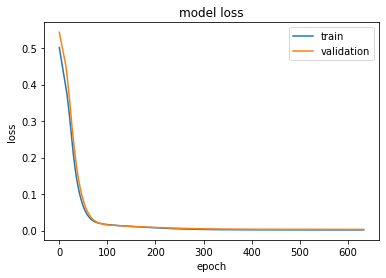

In [ ]:
plot_loss_history(history)